In [ ]:
import OpenDVCW
import tensorflow as tf
from tensorflow.keras.models import Model

In [ ]:
model_dir = "/mnt/WindowsDev/PreTainedModels/OpenDVCW/HAAR200k/model_save_checkpoints_wavelets_haar_Lmbd_256_nfilt_256_epcs_5_stps_200000_I_QP_42_240x240_CosineDecay_20221207-161406/"
model = tf.keras.models.load_model(model_dir)

In [ ]:

i_frame = "/mnt/WindowsDev/DataSets/Beauty_1920x1080_120fps_420_8bit_YUV_RAW/im0.png"
p_frame = "/mnt/WindowsDev/DataSets/Beauty_1920x1080_120fps_420_8bit_YUV_RAW/im15.png"
comp_bin = "/workspaces/OpenDVCW/Test_com/tmp/tmp.bin"
recon_frame = "/workspaces/OpenDVCW/Test_com/tmp/recon.png"
motion_flow = "/workspaces/OpenDVCW/Test_com/tmp/flow.png"
width = 240
height = 240
channels = 3

Y0_com = OpenDVCW.read_png_crop(i_frame, width, height)
Y1_raw = OpenDVCW.read_png_crop(p_frame, width, height) 
Y0_com = tf.expand_dims(Y0_com, 0)
Y1_raw = tf.expand_dims(Y1_raw, 0)
Y0_com = tf.cast(Y0_com / 255, dtype=tf.float32)
Y1_raw = tf.cast(Y1_raw / 255, dtype=tf.float32)

In [ ]:
# OpenDVCW.compress(model, i_frame, p_frame, comp_bin, width, height)
# OpenDVCW.decompress(model, i_frame, comp_bin, recon_frame, width, height)
flow_tensor = model.get_weights()

In [ ]:
flow_tensor_c = flow_tensor[0, :240, :240, :] * 255
flow_tensor_u8 = tf.saturate_cast(tf.round(flow_tensor_c), tf.uint8)
OpenDVCW.write_png(motion_flow, flow_tensor_u8)

In [ ]:
print(tf.reduce_max(flow_tensor_c))

In [ ]:
flow_tensor

In [1]:
import flyingchairs_data_loader

class flags():
    
    data_dir = "/mnt/WindowsDev/DataSets/FlyingChairs/data/"  #, 'Link to dataset directory.')
    train_list = "/mnt/WindowsDev/DataSets/FlyingChairs/train_0.03split.txt"  #'Link to validation list.')
    val_list ="/mnt/WindowsDev/DataSets/FlyingChairs/val_0.03split.txt"  #, "Link to validation list.")
    losses_weight = [0.32, 0.08, 0.02, 0.01, 0.005]  # Loss weights for 6th to 2nd flow predictions, as described in the original paper.')
    gamma = 0.0004  
    batch_size = 1 
    dataset = 'mixed'  # ['mixed', 'chairs', 'things3d_ft'], None)

    #chedule for training from scratch. Train on the mixed dataset of FlyingChairs and FlyingThings3D.
    lr_boundaries = [400000, 600000, 800000, 1000000]
    lr = 0.0001
    num_steps =1500000
    crop_size =[240, 240]

    steps_per_save =10000
    steps_per_eval = 1000
    log_freq = 50

    random_scale = False  
    random_flip = False  




In [25]:
from IPython.display import clear_output
import flow_vis
import matplotlib.pyplot as plt
import cv2
import numpy as np

def draw_flow(img, flow, step=12):

    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow.numpy()[x,y].T

    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    cv2.polylines(img, lines, 0, (0, 255, 0))

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img, (x1, y1), 1, (0, 255, 0), -1)

    return img

def plot_results(i_frame, p_frame, flow, figsize=(20, 20)):
    clear_output(wait=True) 
    flow_color = flow_vis.flow_to_color(flow, convert_to_bgr=True)

    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ax[0].imshow(i_frame)
    ax[0].axis('off')
    ax[0].set_title("I-Frame")
    
    ax[1].imshow(p_frame)
    ax[1].axis('off')
    ax[1].set_title("P-Frame")
    
    ax[2].imshow(draw_flow(i_frame.numpy(), flow))
    ax[2].axis('off')
    ax[2].set_title("P-Frame")
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


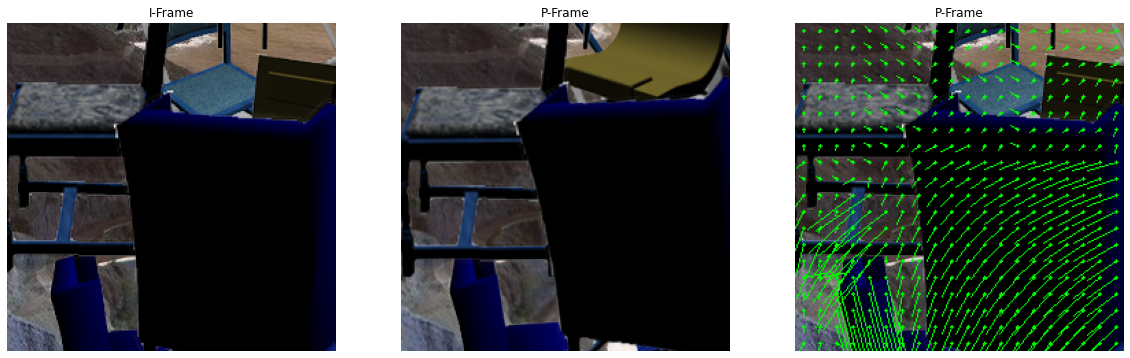

KeyboardInterrupt: 

In [27]:
import matplotlib.pyplot as plt
import time
FLAGS = flags()
data_gen = flyingchairs_data_loader.DataLoader(FLAGS.data_dir, FLAGS.train_list, FLAGS.val_list)
train_dataset, val_dataset = data_gen.create_tf_dataset(FLAGS)
for im_pairs, flo_gt in train_dataset:
    im1 = im_pairs[0, :, :, :3]
    im2 = im_pairs[0, :, :, 3:]
    
    plot_results(im1, im2, flo_gt[0])
    time.sleep(20)